In [1]:
from binpack.models import Result
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from statsmodels.stats import descriptivestats

In [2]:
results = Result.objects.filter(n_tiles=20)

In [3]:
results.values('score')

<QuerySet [{'score': 1.0}, {'score': 1.0}, {'score': 2.0}, {'score': 3.0}, {'score': 0.0}, {'score': 3.0}, {'score': 1.0}, {'score': 3.0}, {'score': 2.0}, {'score': 3.0}, {'score': 1.0}, {'score': 3.0}, {'score': 2.0}, {'score': 4.0}, {'score': 3.0}, {'score': 1.0}, {'score': 1.0}, {'score': 0.0}, {'score': 0.0}, {'score': 0.0}, '...(remaining elements truncated)...']>

In [84]:
def calc_p_value(results, max_depth_instances, avg_depth_instances): 
    max_depth_wins = 0
    avg_depth_wins = 0
    draws = 0
    values = []
    for max_depth_res in max_depth_instances:
        avg_depth_res = results.filter(
            score__isnull=False, strategy='avg_depth',
            cols=max_depth_res.cols, rows=max_depth_res.rows,
            tiles=max_depth_res.tiles, **common_args)
        
        if avg_depth_res.count() == 1:
            avg_depth_score = avg_depth_res.first().score
            max_depth_score = max_depth_res.score
            if avg_depth_score > max_depth_score: # lower is better
                max_depth_wins +=1 
                values.append(1)
            elif avg_depth_score < max_depth_score:
                avg_depth_wins += 1
                values.append(-1)
            else:
                draws += 1
                
    print(f'In total max_depth_wins: {max_depth_wins}, avg_depth_wins: {avg_depth_wins}, and {draws} ties.')
    
    m = descriptivestats.sign_test(values)
    print(f'p value: {m[1]}')

In [85]:

common_args = {'problem_generator': 'florian', 'n_simulations': 1000}

common_args['problem_generator'] = 'guillotine'


# find same problem instances
avg_depth_ids = []
max_depth_ids = []
for max_depth_res in results.filter(score__isnull=False, strategy='max_depth', **common_args):
    avg_depth_score = results.filter(
        score__isnull=False, strategy='avg_depth',
        cols=max_depth_res.cols, rows=max_depth_res.rows,
         tiles=max_depth_res.tiles, **common_args)
    if avg_depth_score:
        avg_depth_ids.append(avg_depth_score.first().id)
        max_depth_ids.append(max_depth_res.id)
g_max_depth_instances = results.filter(id__in=max_depth_ids)
g_avg_depth_instances = results.filter(id__in=avg_depth_ids)
g_max_depth_scores = g_max_depth_instances.values('score')
g_avg_depth_scores = g_avg_depth_instances.values('score')

print('Guillotine')
calc_p_value(Result.objects.filter(**common_args), g_max_depth_instances, g_avg_depth_instances)

common_args['problem_generator'] = 'florian'
ng_avg_depth_instances = results.filter(score__isnull=False, strategy='avg_depth', **common_args)
ng_max_depth_instances = results.filter(score__isnull=False, strategy='max_depth', **common_args)
ng_avg_depth_scores = ng_avg_depth_instances.values('score')
ng_max_depth_scores = ng_max_depth_instances.values('score')
    
print('Non-guillotine')
calc_p_value(Result.objects.filter(**common_args), ng_max_depth_instances, ng_avg_depth_instances)

print(g_avg_depth_scores.count())
print(g_max_depth_scores.count())

print(ng_avg_depth_scores.count())
print(ng_max_depth_scores.count())

# scores = results.values('score', 'strategy')
# print(np.average(np.array(results.filter(score__isnull=False, strategy='avg_depth', **common_args).values_list('rows', flat=True))))
# print(np.average(np.array(results.filter(score__isnull=False, strategy='max_depth', **common_args).values_list('rows', flat=True))))

Guillotine
In total max_depth_wins: 25, avg_depth_wins: 5, and 10 ties.
p value: 0.0003249142318964004
Non-guillotine
In total max_depth_wins: 938, avg_depth_wins: 86, and 148 ties.
p value: 9.869312967488662e-182
39
41
1172
1172


In [30]:
scores_df = pd.DataFrame.from_records(scores)
avg_depth_df = pd.DataFrame.from_records(avg_depth_scores)
def score_to_int(df):
    df['score'] = df['score'].astype('int')
    return df

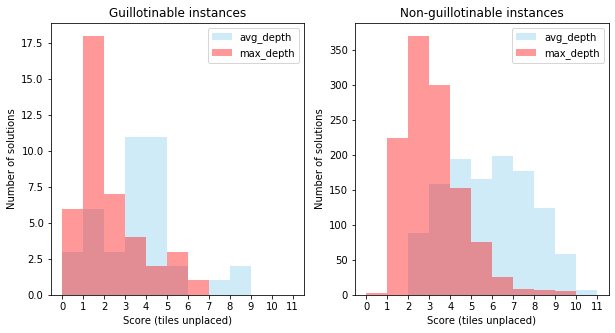

In [46]:
# scores_df
f, axes = plt.subplots(1, 2)

bins = np.arange(0, 12)
for i in range(2):
    if i == 0:
        title = 'Guillotinable instances'
        avg_depth_scores = g_avg_depth_scores
        max_depth_scores = g_max_depth_scores
    else:
        title = 'Non-guillotinable instances'
        avg_depth_scores = ng_avg_depth_scores
        max_depth_scores = ng_max_depth_scores
        
    sns.distplot(score_to_int(pd.DataFrame.from_records(avg_depth_scores)),
                 kde=False, color='skyblue', label='avg_depth', bins=bins, ax=axes[i])
    sns.distplot(score_to_int(pd.DataFrame.from_records(max_depth_scores)),
                      kde=False, color='red', label='max_depth', bins=bins, ax=axes[i])
    axes[i].xaxis.set_major_locator(ticker.MultipleLocator(1))
    axes[i].xaxis.set_major_formatter(ticker.ScalarFormatter())
    # plt.xlim(left=i)
    axes[i].set_ylabel('Number of solutions')
    axes[i].set_xlabel('Score (tiles unplaced)')
    axes[i].set_title(title)
    axes[i].legend()
plt.rcParams["figure.figsize"] = (8,5)
plt.show()

In [7]:
# find total scores by annotation
from django.db.models import Count
results.values('score').annotate(total_for_score=Count('score'))

<QuerySet [{'score': 5.0, 'total_for_score': 1}, {'score': 3.0, 'total_for_score': 1}, {'score': 4.0, 'total_for_score': 1}, {'score': 7.0, 'total_for_score': 1}, {'score': 0.0, 'total_for_score': 1}, {'score': 0.0, 'total_for_score': 1}, {'score': 0.0, 'total_for_score': 1}, {'score': 1.0, 'total_for_score': 1}, {'score': 0.0, 'total_for_score': 1}, {'score': 0.0, 'total_for_score': 1}, {'score': 3.0, 'total_for_score': 1}, {'score': 3.0, 'total_for_score': 1}, {'score': 1.0, 'total_for_score': 1}, {'score': 0.0, 'total_for_score': 1}, {'score': 3.0, 'total_for_score': 1}, {'score': 0.0, 'total_for_score': 1}, {'score': 3.0, 'total_for_score': 1}, {'score': 3.0, 'total_for_score': 1}, {'score': 0.0, 'total_for_score': 1}, {'score': 2.0, 'total_for_score': 1}, '...(remaining elements truncated)...']>

In [8]:
results.count()

2458

### Simulation runs vs score

In [4]:
s1 = set(Result.objects.filter(n_simulations=5000).values_list('their_id', flat=True))
s2 = set(Result.objects.filter(n_simulations=10000).values_list('their_id', flat=True))
s1 - s2
Result.objects.filter(n_simulations=10000)

<QuerySet [2020-01-12 07:05:24.119755+00:00 -20 (35 x 39), 2020-01-12 06:41:19.849995+00:00 -20 (15 x 20), 2020-01-12 06:02:00.509728+00:00 -20 (35 x 36), 2020-01-12 05:53:46.211109+00:00 -20 (15 x 20), 2020-01-12 03:52:18.871395+00:00 -20 (11 x 17), 2020-01-12 03:43:57.699879+00:00 -20 (11 x 17), 2020-01-12 02:03:51.417657+00:00 -20 (35 x 36), 2020-01-12 00:38:04.276890+00:00 -20 (17 x 23), 2020-01-12 00:37:06.645556+00:00 -20 (30 x 34), 2020-01-12 00:24:19.825561+00:00 -20 (17 x 23), 2020-01-11 23:36:45.794624+00:00 -20 (30 x 34), 2020-01-11 21:57:17.942623+00:00 -20 (26 x 27), 2020-01-11 20:52:19.729161+00:00 -20 (26 x 27), 2020-01-11 17:33:30.461394+00:00 -20 (34 x 35), 2020-01-11 17:10:49.498598+00:00 -20 (37 x 28), 2020-01-11 17:07:23.592766+00:00 -20 (21 x 34), 2020-01-11 16:56:53.813628+00:00 -20 (21 x 34), 2020-01-11 15:29:24.478136+00:00 -20 (34 x 35), 2020-01-11 14:48:32.234212+00:00 -20 (37 x 28), 2020-01-11 13:39:51.716649+00:00 -20 (33 x 32), '...(remaining elements trunc

100 13
500 13
1000 13
2000 13
5000 13
10000 12
[0 1 2 3 4 5]
Number of tiles non-placed in correlation with simulation runs


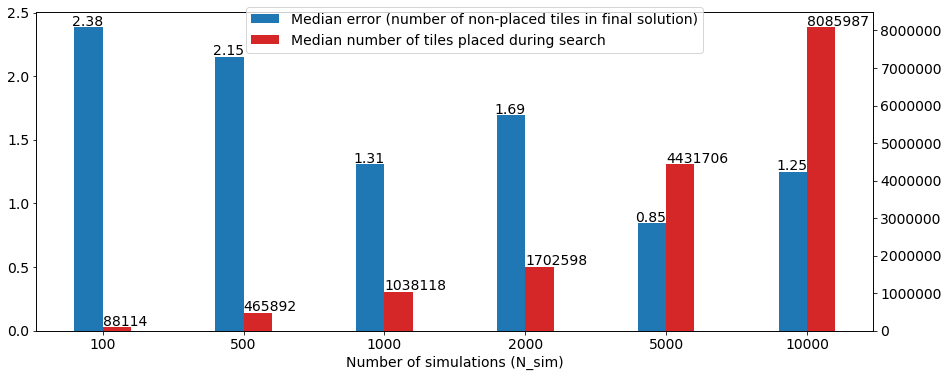

In [174]:
from collections import defaultdict, OrderedDict
from matplotlib.ticker import FuncFormatter, MaxNLocator
SIMULATION_RUNS = [100, 500, 1000, 2000, 5000, 10000]
def format_fn(tick_val, tick_pos):
    if int(tick_val) in range(0, len(SIMULATION_RUNS)):
        return SIMULATION_RUNS[int(tick_val)]
    else:
        return ''
problem_ids = Result.objects.filter(n_simulations=500, score__isnull=False, problem_generator='guillotine').values_list('problem_id')
x_vals = defaultdict(list)
results = OrderedDict()

plt.rcParams["figure.figsize"] = (15,3)

for n_simulations in SIMULATION_RUNS:
    common_args = {
        'problem_id__in': problem_ids, 'strategy': 'max_depth', 'n_simulations': n_simulations,
        'score__isnull': False
    }
    avg_score = np.average(np.array(Result.objects.filter(
        **common_args).order_by('their_id').values_list('score', flat=True)))
    results[n_simulations] = {'median score': avg_score}
    avg_tiles = np.average(np.array(Result.objects.filter(
        **common_args).order_by('their_id').values_list('n_tiles_placed', flat=True)))
    print(n_simulations, Result.objects.filter(**common_args).count())
    results[n_simulations]['median tiles placed'] = avg_tiles
    
fig,  ax1 = plt.subplots()
x = np.arange(0, len(SIMULATION_RUNS) )
print(x)
y = np.arange(0,3)
width_offset = 0.10
width = 0.2 
for i, score_type in enumerate(['median score', 'median tiles placed']):
    # print(result)
    sc = [v[score_type] for k, v in results.items()]
    current_ax = ax1
    color = 'tab:blue'
    label = 'Median error (number of non-placed tiles in final solution)'
    if i == 1:
        color = 'tab:red'
        ax2 = ax1.twinx()
        current_ax = ax2
        width_offset = -width_offset
        label = 'Median number of tiles placed during search'
    current_ax.bar(x - width_offset, sc, width=width, 
            label=label, color=color)
    current_ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
    current_ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    for i, v in enumerate(sc): 
        offset = width_offset 
        text = '{:.2f}'.format(v)
        _offset = 0.12
        _offset_top = 0.01
        if v >  10:
            text = '{:.0f}'.format(v)
            _offset = 0.10
            _offset_top = 50000.35
        current_ax.text(x[i] - offset - _offset, v + _offset_top, text)
   
plt.rcParams["font.size"] = 14
# plt.yticks(ticks=np.arange(0, 4))
ax1.set_xlabel('Number of simulations (N_sim)')
# ax1.set_ylabel('Median error (number of non-placed tiles in final solution)')
# ax2.set_ylabel('Median number of tiles placed during search')
fig.legend(loc='upper center')
fig.subplots_adjust(top=1.6)
print('Number of tiles non-placed in correlation with simulation runs')
plt.show()

### Tiles placed (Huristic vs MCTS)

In [14]:
instances_where_solution_is_found = Result.objects.filter(solution_found=True, n_tiles=20, problem_generator='florian').values('n_tiles_placed', 'their_tiles_placed')
scores_df = pd.DataFrame.from_records(instances_where_solution_is_found)
scores_df

,n_tiles_placed,their_tiles_placed
0,858933,29007
1,962642,22
2,843695,77


In [11]:
solutions_found = Result.objects.filter(solution_found=True, n_tiles=20, problem_generator='florian', n_simulations=1000).count()
solutions_not_found = Result.objects.filter(solution_found=False, n_tiles=20, problem_generator='florian', n_simulations=1000).count()
print('Florian instances')
print(f'solutions found: {solutions_found} \nsolutions not found: {solutions_not_found}')
print(f'perc: {solutions_found / solutions_not_found * 100} %')

Florian instances
solutions found: 3 
solutions not found: 402
perc: 0.7462686567164178 %


In [10]:
print('Guillotine instances')
solutions_found = Result.objects.filter(solution_found=True, n_tiles=20, problem_generator='guillotine', n_simulations=1000).count()
solutions_not_found = Result.objects.filter(solution_found=False, n_tiles=20, problem_generator='guillotine', n_simulations=1000).count()
print(f'solutions found: {solutions_found} \nsolutions not found: {solutions_not_found}')
print(f'perc: {solutions_found / solutions_not_found * 100} %')

Guillotine instances
solutions found: 58 
solutions not found: 94
perc: 61.702127659574465 %
